In [135]:
import os
import sys
import subprocess
from pathlib import Path
import torch


In [136]:
WORK_DIR = Path("/content/sam2_project")
CHECKPOINT_DIR = WORK_DIR / "checkpoints"
FRAMES_DIR = WORK_DIR / "video_frames"
OUTPUT_DIR = WORK_DIR / "outputs"
CACHE_DIR = WORK_DIR / ".cache"
for directory in [WORK_DIR, CHECKPOINT_DIR, FRAMES_DIR, OUTPUT_DIR, CACHE_DIR]:
    directory.mkdir(parents=True, exist_ok=True)
os.chdir(WORK_DIR)

INSTALL_MARKER = CACHE_DIR / "install_complete.txt"
if not INSTALL_MARKER.exists():
    subprocess.run([
        sys.executable, "-m", "pip", "install", "-q",
        "torch>=2.5.1", "torchvision>=0.20.1",
        "--index-url", "https://download.pytorch.org/whl/cu121"
    ], check=True)
    if not (WORK_DIR / "sam2").exists():
        subprocess.run(["git", "clone", "-q", "https://github.com/facebookresearch/sam2.git"], check=True)
    os.chdir(WORK_DIR / "sam2")
    os.environ['SAM2_BUILD_CUDA'] = '0'
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-e", "."], check=True)
    os.chdir(WORK_DIR)
    subprocess.run([
        sys.executable, "-m", "pip", "install", "-q",
        "ultralytics", "supervision", "opencv-python", "matplotlib", "pillow", "tqdm"
    ], check=True)
    INSTALL_MARKER.write_text("Installation completed successfully")


In [137]:
import urllib.request
from tqdm import tqdm

def download_with_progress(url, destination):
    if destination.exists():
        return
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None: self.total = tsize
            self.update(b * bsize - self.n)
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1) as t:
        urllib.request.urlretrieve(url, destination, reporthook=t.update_to)

SAM_CHECKPOINTS = {
    "tiny": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt",
    "small": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt",
    "base_plus": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt",
    "large": "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"
}
SAM_MODEL_SIZE = "base_plus"
sam_checkpoint_path = CHECKPOINT_DIR / f"sam2.1_hiera_{SAM_MODEL_SIZE}.pt"
download_with_progress(SAM_CHECKPOINTS[SAM_MODEL_SIZE], sam_checkpoint_path)


In [138]:
import gc
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
torch.set_float32_matmul_precision('high')
clear_memory()


In [139]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Optional, Dict
import json
sys.path.append(str(WORK_DIR / "sam2"))
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor
from ultralytics import YOLO
import supervision as sv


In [140]:
SAM_CONFIGS = {
    "tiny": "configs/sam2.1/sam2.1_hiera_t.yaml",
    "small": "configs/sam2.1/sam2.1_hiera_s.yaml",
    "base_plus": "configs/sam2.1/sam2.1_hiera_b+.yaml",
    "large": "configs/sam2.1/sam2.1_hiera_l.yaml"
}
grounding_model = YOLO('yolov8l-world.pt')
sam_model_cfg = SAM_CONFIGS[SAM_MODEL_SIZE]
sam_model = build_sam2(sam_model_cfg, str(sam_checkpoint_path))
sam_predictor = SAM2ImagePredictor(sam_model)
clear_memory()


In [141]:
def ground_text_to_boxes(image: np.ndarray, text_prompt: str, confidence_threshold: float = 0.25):
    classes = [cls.strip() for cls in text_prompt.split(',')]
    grounding_model.set_classes(classes)
    results = grounding_model(image, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    valid_mask = confidences >= confidence_threshold
    boxes = boxes[valid_mask]
    confidences = confidences[valid_mask]
    class_ids = class_ids[valid_mask]
    labels = [classes[cid] for cid in class_ids]
    return boxes, confidences, labels

def segment_from_boxes(image: np.ndarray, boxes: np.ndarray, multimask_output: bool = False):
    if len(boxes) == 0: return np.array([]), np.array([])
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        sam_predictor.set_image(image)
        all_masks, all_scores = [], []
        for box in boxes:
            masks, scores, _ = sam_predictor.predict(box=box, multimask_output=multimask_output)
            idx = np.argmax(scores) if multimask_output else 0
            # FIX: Convert to boolean type
            all_masks.append(masks[idx].astype(bool))  # Add .astype(bool)
            all_scores.append(scores[idx])
    return np.array(all_masks), np.array(all_scores)

def text_to_segmentation(image_path: str, text_prompt: str, confidence_threshold: float = 0.25, output_path: Optional[str] = None):
    image_bgr = cv2.imread(str(image_path))
    if image_bgr is None: raise ValueError(f"Failed to load image: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    boxes, confidences, labels = ground_text_to_boxes(image_bgr, text_prompt, confidence_threshold)
    masks, scores = segment_from_boxes(image_rgb, boxes)
    detections = sv.Detections(xyxy=boxes, mask=masks, confidence=confidences, class_id=np.arange(len(boxes)))
    mask_annotator, box_annotator, label_annotator = sv.MaskAnnotator(), sv.BoxAnnotator(), sv.LabelAnnotator()
    annotated = image_bgr.copy()
    annotated = mask_annotator.annotate(annotated, detections)
    annotated = box_annotator.annotate(annotated, detections)
    label_texts = [f"{label} {conf:.2f}" for label, conf in zip(labels, confidences)]
    annotated = label_annotator.annotate(annotated, detections, labels=label_texts)
    if output_path: cv2.imwrite(str(output_path), annotated)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.show()
    clear_memory()
    return {'masks': masks, 'boxes': boxes, 'labels': labels, 'confidences': confidences, 'scores': scores, 'annotated_image': annotated}


Saving 61UtIjz4FwS._AC_SL1500_.jpg to 61UtIjz4FwS._AC_SL1500_.jpg


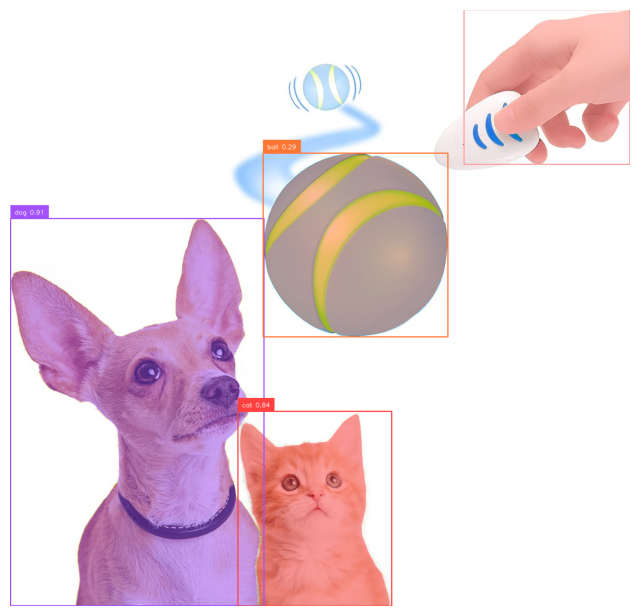

Found 4 objects: ['dog', 'cat', 'person', 'ball']


In [142]:
# Example: Upload and Run Segmentation
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
results = text_to_segmentation(image_path=image_path, text_prompt="person, car, dog, cat, car, ball", confidence_threshold=0.25, output_path=str(OUTPUT_DIR / "result.jpg"))
print(f"Found {len(results['masks'])} objects: {results['labels']}")
